In [1]:
import nltk
from nltk.corpus import brown
nltk.download('brown')
import numpy as np
from numba import njit

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Pranav\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


# Hidden Markov Model
|||
|---|---|
| $Q=q_1q_2\dots q_N$ | a set of N states|
| $A=a_{11}\dots a_{ij}\dots a_{NN}$ | a transition probability matrix $A$, each $a_{ij}$ representing the probability of moving from state $i$ to state $j$, s.t. $\sum_{j=1}^N a_{ij} = 1 \ \forall i$|
| $B=b_i(o_t)$ | a sequence of observation likelihoods, also called emission probabilities, each expressing the probability of an observation $o_t$ (drawn from a vocabulary $V = v_1, v_2, \dots, v_V$) being generated from a state $q_i$|
|$\pi = \pi_1, \pi_2, \dots, \pi_N$| an initial probability distribution over states. $\pi_i$ is the probability that the Markov chain will start in state $i$. Some states $j$ may have $\pi_j = 0$, meaning that they cannot be initial states. Also, $\sum_{i=1}^N \pi_i = 1$|



# Calculating prior probabilities

In [2]:
words = sorted(list(set(brown.words())))
pos_tags = ['VERB','NOUN','PRON','ADJ','ADV','ADP','CONJ','DET','NUM','PRT','.','X']
# pos_tags = list(set(pair[1] for pair in brown.tagged_words(tagset='universal')))
tagged_sents = list(brown.tagged_sents(tagset='universal'))

In [3]:
def to_numpy(XY:list[list[tuple[str,str]]], X_name:list, Y_name:list, to_sort=False):
    X_id_map = {v: i for i, v in enumerate(X_name)}
    Y_id_map = {v: i for i, v in enumerate(Y_name)}
    if to_sort: XY = sorted(XY,key=len)
        
    n = len(XY)
    m = max(len(s) for s in XY)
    ST = np.zeros((n, m, 2), dtype=np.int32)-1

    for i, s in enumerate(XY):
        for j, w in enumerate(s):
            ST[i, j] = np.array([X_id_map[w[0]], Y_id_map[w[1]]])

    return ST

ST = to_numpy(tagged_sents, words, pos_tags)

In [4]:
@njit
def get_prob(stB:np.ndarray, no_words:int, no_tags:int, eps:float=0.00001):
    A = np.zeros((no_tags,no_tags), dtype=np.float64)
    B = np.zeros((no_tags,no_words), dtype=np.float64)
    Pi = np.zeros(no_tags, dtype=np.float64)

    m, n, _ = stB.shape
    
    for i in range(m):
        if stB[i,0,0] == -1 : break
        Pi[stB[i,0,1]] += 1
        for j in range(n-1):
            wnth = stB[i,j,0]
            nth, nnth = stB[i,j:j+2,1]
            B[nth, wnth] += 1
            if nnth == -1 : break
            A[nth,nnth] += 1
        if nnth != -1 : B[stB[i,n-1,1], stB[i,n-1,0]] += 1
    A /= np.sum(A,axis=1).reshape(-1,1) + eps
    B /= np.sum(B,axis=1).reshape(-1,1) + eps
    Pi /= np.sum(Pi) + eps
    return A, B, Pi

A, B, Pi = get_prob(ST, len(words), len(pos_tags))

In [5]:
np.savez_compressed('hmm_probs', A=A, B=B, Pi=Pi)

In [6]:
loaded = np.load('hmm_probs.npz')
A2  = loaded['A']
B2  = loaded['B']
Pi2 = loaded['Pi']
print(np.array_equal(A,A2), np.array_equal(B,B2), np.array_equal(Pi,Pi2))

True True True


# Viterbi parameters
|||
|---|---|
 |$v_{t-1}(i)$ | the previous Viterbi path probability from the previous time step|
 |$a_{ij}$ | the transition probability from previous state $q_i$ to current state $q_j$|
 |$b_j(o_t)$| the state observation likelihood of the observation symbol ot given the current state $j$|

In [7]:
from viterbi import viterbi_log

# ST = to_numpy(tagged_sents, words, pos_tags)
# A, B, Pi = get_prob(ST, len(words), len(pos_tags))

r = 1028              # sample number to test
test_sent = []
test_tags = []
for word, tag in tagged_sents[r]:
    test_sent.append(word)
    test_tags.append(tag)
O = [words.index(word) for word in test_sent] # producing observation states (words) in terms of its word index

optim_state_seq, log_prob_trellis, backtrack_matrix = viterbi_log(O,A,Pi,B)

optim_state_seq = [pos_tags[t] for t in optim_state_seq]

# The following was to check if it was working or not. These parts need to be better done.
print('Observation sequence:   O  = ', test_sent)
print('Correct state sequence: S* = ', test_tags)
print('Optimal state sequence: S  = ', optim_state_seq)
print("Do they match ? : ", test_tags==optim_state_seq)

from pandas import DataFrame
test_result_df = DataFrame(index=test_sent,columns=['Correct','Guessed'],data=zip(test_tags,optim_state_seq)).T
test_result_df.iloc[:,(test_result_df.nunique()!=1).values]

Observation sequence:   O  =  ['Catcher', 'Frank', "House's", 'throw', 'in', 'an', 'effort', 'to', 'nab', 'Throneberry', 'was', 'wide', 'and', 'in', 'the', 'dirt', '.']
Correct state sequence: S* =  ['NOUN', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'DET', 'NOUN', 'PRT', 'VERB', 'NOUN', 'VERB', 'ADV', 'CONJ', 'ADP', 'DET', 'NOUN', '.']
Optimal state sequence: S  =  ['NOUN', 'NOUN', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', 'PRT', 'VERB', 'NOUN', 'VERB', 'ADJ', 'CONJ', 'ADP', 'DET', 'NOUN', '.']
Do they match ? :  False


,throw,wide
Correct,NOUN,ADV
Guessed,VERB,ADJ


# Kfold 

In [8]:
@njit
def viterbi_prmt(Xx,A,Pi,B):
    out = np.zeros(Xx.shape, dtype=np.int16)-1
    Xx = Xx[Xx>-1]
    out[:Xx.shape[0]], _, _ = viterbi_log(Xx, A, Pi, B)
    return out

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

# Define number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=89)
# Get array version of the tagged sentences
ST = to_numpy(tagged_sents, words, pos_tags)

accuracies = []
conf_matrices = []

for train_index, test_index in kf.split(ST):
    # Split data into training and testing sets
    train_ST = ST[train_index]
    test_ST =  ST[test_index]
    test_ST_o, test_ST_q = np.moveaxis(test_ST,-1,0)

    A, B, Pi = get_prob(train_ST, len(words), len(pos_tags))
    
    # Testing
    pred = np.apply_along_axis(viterbi_prmt,1,test_ST_o,A,Pi,B)
    
    assert ((pred == -1) == (test_ST_q == -1)).all()
    conf_matx = confusion_matrix(pred[pred!=-1].ravel(),test_ST_q[test_ST_q!=-1].ravel())
    # Per label accuracy which i think turns out same as precision
    prec_s = conf_matx.sum(axis=0)
    prec_s[prec_s==0] = 1 # handling division by zero
    precis = conf_matx.diagonal() / prec_s
    # i'll do recall also, just in case
    # rec_s = conf_matx.sum(axis=1)
    # rec_s[rec_s==0] = 1 # handling division by zero
    # recal = conf_matx.diagonal() / rec_s
    
    accuracies.append(precis)
    conf_matrices.append(conf_matx)  

per_tag_acc = np.array(accuracies).mean(axis=0)
print('Per tag accuracies :\n',per_tag_acc)

Per tag accuracies :
 [0.95071283 0.94981182 0.9850441  0.91142681 0.89520908 0.96835217
 0.99499212 0.98674635 0.91368055 0.90717005 0.999844   0.49413643]


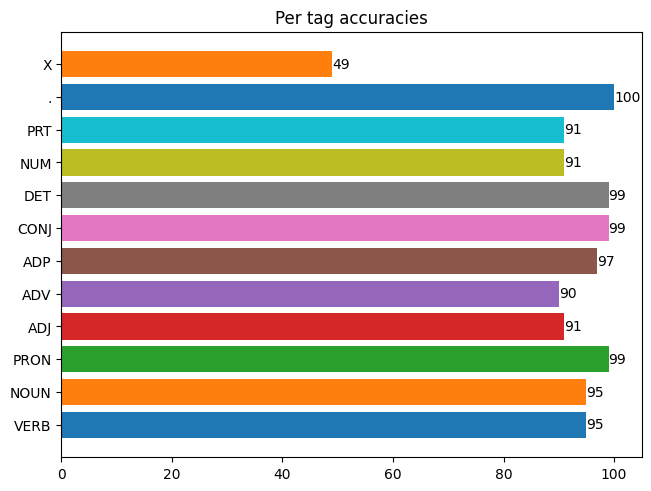

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(layout='constrained')
bars = ax.barh(pos_tags, np.round(per_tag_acc,2)*100,color=['C'+str(k) for k in range(12)])
ax.bar_label(bars)
ax.set_title('Per tag accuracies')
plt.show()

# From Module

In [2]:
from HMM import POSTagger
from nltk.corpus import brown
words = list(set(brown.words()))
pos_tags = ['VERB','NOUN','PRON','ADJ','ADV','ADP','CONJ','DET','NUM','PRT','.','X']
tagged_sents = list(brown.tagged_sents(tagset='universal'))
ht = POSTagger(tagged_sentences=tagged_sents)
st = ht.get_ST()
i=543
tsent = tagged_sents[i]
twidx = st[i]
print(f'No. of tokens in sentence: {len(tsent)}\n {tsent}')
print(f'Length of row: {len(twidx)}\n {twidx}')
print(ht.pos_tags)


2024-09-06 23:15:42,895 [INFO] POSTagger - Initializing Hidden Markov Model.
Getting all tags: 100%|██████████| 57340/57340 [00:00<00:00, 780243.22it/s]

2024-09-06 23:15:44,930 [INFO] POSTagger - Calculating probability matrices...


No. of tokens in sentence: 17
 [('He', 'PRON'), ('introduced', 'VERB'), ('regular', 'ADJ'), ('briefing', 'VERB'), ('sessions', 'NOUN'), ('for', 'ADP'), ('district', 'NOUN'), ('fire', 'NOUN'), ('wardens', 'NOUN'), ('and', 'CONJ'), ('first', 'ADJ'), ('aid', 'NOUN'), ('training', 'NOUN'), ('for', 'ADP'), ('section', 'NOUN'), ('wardens', 'NOUN'), ('.', '.')]
Length of row: 180
 [[ 9169    10]
 [36375     5]
 [45719     9]
 [23152     5]
 [48017     1]
 [31946     2]
 [28656     1]
 [31482     1]
 [54961     1]
 [20512     4]
 [31511     9]
 [20078     1]
 [52733     1]
 [31946     2]
 [47630     1]
 [54961     1]
 [  405     3]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1    -1]
 [   -1 

In [16]:
from HMM import initialize_hmm_tagger
from nltk.corpus import brown
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

tagged_sents = list(brown.tagged_sents(tagset='universal'))
hmm_tagger, words, pos_tags = initialize_hmm_tagger()
train_ST = hmm_tagger.get_ST()
test_ST = train_ST
test_ST_o, test_ST_q = np.moveaxis(test_ST,-1,0)

pred = hmm_tagger.batch_tag(test_ST_o)
assert ((pred == -1) == (test_ST_q == -1)).all()
y_true = test_ST_q[test_ST_q!=-1].ravel()
y_pred = pred[pred!=-1].ravel()

precision_s, recall_s, fscore_s, _ = precision_recall_fscore_support(
    y_true, y_pred, 
    beta=1, 
    labels=range(12)
)



2024-09-06 14:58:33,257 [INFO] POSTagger - Initializing Hidden Markov Model.

2024-09-06 14:58:35,123 [INFO] POSTagger - Calculating probability matrices...

2024-09-06 14:58:35,362 [INFO] POSTagger - Evaluating optimal state sequences using log-viterbi algorithm...


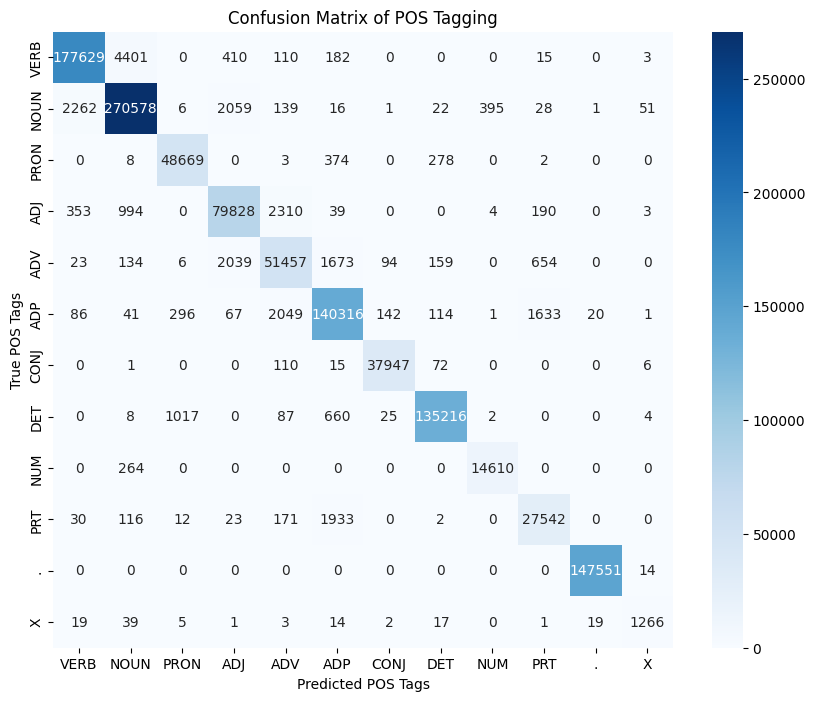

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matx = confusion_matrix(y_true, y_pred, labels=range(len(pos_tags)))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matx, annot=True, fmt='d', cmap='Blues', xticklabels=pos_tags, yticklabels=pos_tags)

plt.xlabel('Predicted POS Tags')
plt.ylabel('True POS Tags')
plt.title('Confusion Matrix of POS Tagging')
plt.show()